<a href="https://colab.research.google.com/github/yogasgm/data-science-machine-learning-BI/blob/main/DS/002_Nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Time Series Nowcasting with Lag Features**
This notebook will demonstrate various steps in time series forecasting, including loading data, creating lag features, preparing training and target variables, defining models, performing time series cross-validation, analyzing model performance, and making predictions.

## About the Dummy Dataset: synthetic_nowcasting_data.csv
This dataset consists of **120 months of economic data** spanning **from January 1, 2015, to December 2024**. It includes several key economic indicators designed to reflect real-world financial trends and relationships between macroeconomic variables. The dataset captures temporal dependencies and interactions between various features. Some of the key features include:  

- **GDP_Growth**: Represents **monthly economic growth (%)**. Higher GDP growth is typically associated with lower unemployment and higher consumer confidence.  
- **Unemployment_Rate**: Simulated with a **negative correlation** to GDP_Growth, meaning that when economic growth is strong, unemployment tends to be lower.  
- **Money_Supply**: Modeled with an **increasing trend over 10 years**, which can contribute to rising **Inflation_Rate** as more money circulates in the economy.  
- **Inflation_Rate**: Influenced by **Money_Supply**—when money supply increases, inflation tends to rise due to higher demand and currency devaluation.  
- **Interest_Rate**: Determined based on inflation levels. **Central banks** typically raise interest rates to curb inflation, meaning **higher inflation often leads to higher interest rates**.  
- **Exchange_Rate**: Represents the **local currency exchange rate (e.g., Rupiah per USD)**. It is affected by both **Money_Supply** (loose monetary policy can cause depreciation) and **Interest_Rate** (higher interest rates tend to attract foreign investment, strengthening the currency).  
- **Consumer_Confidence_Index**: Formed by combining the **positive influence of GDP_Growth** and the **negative impact of Unemployment_Rate**. This index reflects consumer sentiment towards the economy.  

## **Importing Required Libraries**
We will import the necessary libraries for data processing, machine learning modeling, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

## **Loading the Dataset**
We will load the dataset into a pandas DataFrame for further preprocessing and analysis.

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/yogasgm/data-science-machine-learning-BI/refs/heads/main/dataset/synthetic_nowcasting_data.csv")
data

,Date,GDP_Growth,Unemployment_Rate,Exchange_Rate,Interest_Rate,Money_Supply,Consumer_Confidence_Index,Inflation_Rate
0,2015-01-01,1.00,6.90,13000.00,4.06,98.41,106.83,2.10
1,2015-02-01,0.36,6.36,13000.00,4.50,100.19,95.16,2.79
2,2015-03-01,1.15,7.13,13164.60,3.65,101.85,98.61,2.13
3,2015-04-01,2.02,5.29,13179.05,4.56,102.99,118.97,2.50
4,2015-05-01,0.27,7.16,13000.00,4.05,99.28,101.70,2.27
...,...,...,...,...,...,...,...,...
115,2024-08-01,0.80,6.92,14940.65,8.35,146.31,105.43,6.51
116,2024-09-01,0.47,5.75,14888.79,9.08,148.70,113.81,7.16
117,2024-10-01,-0.67,7.43,14922.12,8.72,148.58,90.38,7.01
118,2024-11-01,1.64,5.85,14782.03,10.43,150.23,116.59,8.56


## **Creating Lag Features**
To capture temporal dependencies in the data, we will generate lag features. These lag features will enable the model to recognize short-term trends when estimating current economic conditions.

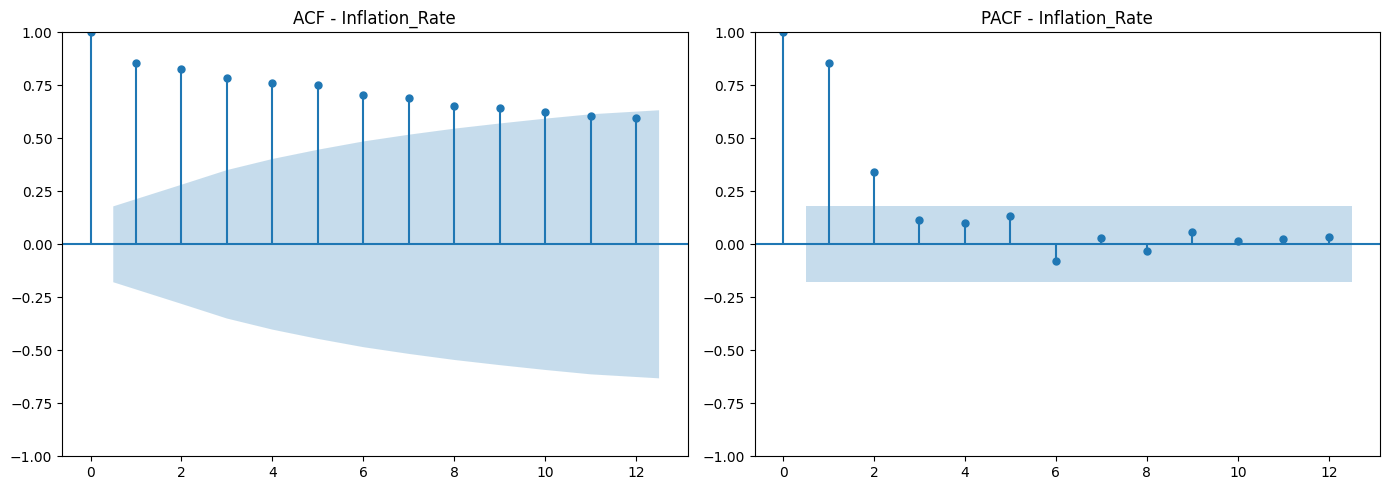

In [3]:
# Let's focus on the target variable: 'Inflation_Rate'
target_series = data['Inflation_Rate']

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(target_series, ax=axes[0], lags=12)  # Adjust lags as necessary (e.g., 12 months for monthly data)
axes[0].set_title('ACF - Inflation_Rate')

plot_pacf(target_series, ax=axes[1], lags=12)
axes[1].set_title('PACF - Inflation_Rate')

plt.tight_layout()
plt.show()

Optimal Lag Selection: **1**  

📌 Why Lag **1**?  
- **Reason (PACF):** The first significant spike appears at **lag 1**, indicating a strong direct influence of the previous month's inflation rate on the current inflation rate.  
- **Reason (ACF):** The autocorrelation function shows persistence in the data, meaning past values continue to have an impact over time.  

❓ Why Not Lag 0?  
- **Lag 0 represents the current value itself**, which means it is not a past observation.  
- Since the goal of nowcasting is to estimate the current inflation rate based on past data, using lag 0 as a feature would be meaningless—it would simply be the value we are trying to predict.  

In [ ]:
# Add lag features
def create_lag_features(df, lag=1):
    df_copy = df.copy()
    for col in df.columns:
        if col != 'Date':
            df_copy[col + f'_lag{lag}'] = df_copy[col].shift(lag)
    return df_copy

# Create lag features
data_lagged = create_lag_features(data, lag=1)
data_lagged

,Date,GDP_Growth,Unemployment_Rate,Exchange_Rate,Interest_Rate,Money_Supply,Consumer_Confidence_Index,Inflation_Rate,GDP_Growth_lag1,Unemployment_Rate_lag1,Exchange_Rate_lag1,Interest_Rate_lag1,Money_Supply_lag1,Consumer_Confidence_Index_lag1,Inflation_Rate_lag1
0,2015-01-01,1.00,6.90,13000.00,4.06,98.41,106.83,2.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-01,0.36,6.36,13000.00,4.50,100.19,95.16,2.79,1.00,6.90,13000.00,4.06,98.41,106.83,2.10
2,2015-03-01,1.15,7.13,13164.60,3.65,101.85,98.61,2.13,0.36,6.36,13000.00,4.50,100.19,95.16,2.79
3,2015-04-01,2.02,5.29,13179.05,4.56,102.99,118.97,2.50,1.15,7.13,13164.60,3.65,101.85,98.61,2.13
4,2015-05-01,0.27,7.16,13000.00,4.05,99.28,101.70,2.27,2.02,5.29,13179.05,4.56,102.99,118.97,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,0.80,6.92,14940.65,8.35,146.31,105.43,6.51,0.31,7.92,14747.31,9.92,147.86,98.61,7.61
116,2024-09-01,0.47,5.75,14888.79,9.08,148.70,113.81,7.16,0.80,6.92,14940.65,8.35,146.31,105.43,6.51
117,2024-10-01,-0.67,7.43,14922.12,8.72,148.58,90.38,7.01,0.47,5.75,14888.79,9.08,148.70,113.81,7.16
118,2024-11-01,1.64,5.85,14782.03,10.43,150.23,116.59,8.56,-0.67,7.43,14922.12,8.72,148.58,90.38,7.01


In [ ]:
# Drop rows with NaN values due to lag
data_lagged = data_lagged.dropna()
data_lagged

,Date,GDP_Growth,Unemployment_Rate,Exchange_Rate,Interest_Rate,Money_Supply,Consumer_Confidence_Index,Inflation_Rate,GDP_Growth_lag1,Unemployment_Rate_lag1,Exchange_Rate_lag1,Interest_Rate_lag1,Money_Supply_lag1,Consumer_Confidence_Index_lag1,Inflation_Rate_lag1
1,2015-02-01,0.36,6.36,13000.00,4.50,100.19,95.16,2.79,1.00,6.90,13000.00,4.06,98.41,106.83,2.10
2,2015-03-01,1.15,7.13,13164.60,3.65,101.85,98.61,2.13,0.36,6.36,13000.00,4.50,100.19,95.16,2.79
3,2015-04-01,2.02,5.29,13179.05,4.56,102.99,118.97,2.50,1.15,7.13,13164.60,3.65,101.85,98.61,2.13
4,2015-05-01,0.27,7.16,13000.00,4.05,99.28,101.70,2.27,2.02,5.29,13179.05,4.56,102.99,118.97,2.50
5,2015-06-01,0.27,7.96,13257.68,3.52,101.43,97.52,1.94,0.27,7.16,13000.00,4.05,99.28,101.70,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,2024-08-01,0.80,6.92,14940.65,8.35,146.31,105.43,6.51,0.31,7.92,14747.31,9.92,147.86,98.61,7.61
116,2024-09-01,0.47,5.75,14888.79,9.08,148.70,113.81,7.16,0.80,6.92,14940.65,8.35,146.31,105.43,6.51
117,2024-10-01,-0.67,7.43,14922.12,8.72,148.58,90.38,7.01,0.47,5.75,14888.79,9.08,148.70,113.81,7.16
118,2024-11-01,1.64,5.85,14782.03,10.43,150.23,116.59,8.56,-0.67,7.43,14922.12,8.72,148.58,90.38,7.01


## **Preparing Features and Target Variable**
We will define the independent variables and the target variable.

In [ ]:
# Define feature variables (only lagged features)
X_lagged = data_lagged[['GDP_Growth_lag1', 'Unemployment_Rate_lag1',
                        'Exchange_Rate_lag1', 'Interest_Rate_lag1',
                        'Money_Supply_lag1', 'Consumer_Confidence_Index_lag1']]

# Define target variable (Inflation Rate)
y_lagged = data_lagged['Inflation_Rate']

## **Defining Models for Forecasting**
We will implement multiple nowcasting models, including:
* **Linear Regression**, which serves as a baseline model.
* **Random Forest Regressor**, which captures complex, non-linear relationships in the data.

The performance of these models will be compared to determine the most effective approach.


In [ ]:
# Initialize dictionary to store models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Initialize dictionary to store evaluation metrics
results_corrected = {
    'Model': [],
    'RMSE': [],
    'R2': [],
    'MAE': [],
}

## **Time Series Cross-Validation**
Since nowcasting requires sequential data integrity, we will apply TimeSeriesSplit cross-validation to evaluate model performance. The dataset will be divided into training and test sets while maintaining the chronological order of observations.

In [ ]:
# Initialize TimeSeriesSplit with 5 splits
tscv = TimeSeriesSplit(n_splits=5)

# Train and evaluate models using time series cross-validation
for model_name, model in models.items():
    # Split train and test data
    for train_index, test_index in tscv.split(X_lagged):
        X_train, X_test = X_lagged.iloc[train_index], X_lagged.iloc[test_index]
        y_train, y_test = y_lagged.iloc[train_index], y_lagged.iloc[test_index]

        # Train the model
        model.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        # Store results
        results_corrected['Model'].append(model_name)
        results_corrected['RMSE'].append(rmse)
        results_corrected['R2'].append(r2)
        results_corrected['MAE'].append(mae)

## **Analyzing Model Performance**
To assess model accuracy, we will compute multiple evaluation metrics:

* **Root Mean Squared Error (RMSE)** to measure prediction error.
* **R-squared (R²)** to evaluate how well the model explains variance in the target variable.
* **Mean Absolute Error (MAE)** to analyze the average prediction deviation.

The average performance of each model will be calculated to determine the best nowcasting approach.

In [ ]:
# Convert results to DataFrame
results_corrected_df = pd.DataFrame(results_corrected)
results_corrected_df

,Model,RMSE,R2,MAE
0,Linear Regression,0.925949,-2.821121,0.821426
1,Linear Regression,0.682762,-0.101757,0.563965
2,Linear Regression,0.594314,0.024689,0.508533
3,Linear Regression,0.616933,-0.242167,0.496420
4,Linear Regression,0.627838,0.117371,0.448031
5,Random Forest,1.056323,-3.972910,0.901395
6,Random Forest,0.870150,-0.789518,0.710542
7,Random Forest,0.721304,-0.436641,0.593958
8,Random Forest,0.666596,-0.450205,0.551516
9,Random Forest,1.144653,-1.933795,0.902363


In [ ]:
# Calculate the average of the evaluation metrics
average_results = results_corrected_df.groupby('Model').mean().reset_index()

# Display the average results
average_results

,Model,RMSE,R2,MAE
0,Linear Regression,0.689559,-0.604597,0.567675
1,Random Forest,0.891805,-1.516614,0.731955


## **Training Final Models on Full Dataset**
Once the best-performing models are identified, we will retrain them using the entire dataset to maximize predictive power for real-time analysis.

In [ ]:
# Initialize dictionary to store trained models
final_models_corrected = {}

# Train models using the entire dataset
for model_name, model in models.items():
    model.fit(X_lagged, y_lagged)
    final_models_corrected[model_name] = model

## **Forecasting Inflation Rate for December 2024**
Finally, we will use the trained models to nowcast the Inflation Rate for December 2024.

In [ ]:
# Extract latest available data (December 2024) for forecasting
december_2024_data = data.iloc[-1][['GDP_Growth', 'Unemployment_Rate',
                                'Exchange_Rate', 'Interest_Rate',
                                'Money_Supply', 'Consumer_Confidence_Index']]

# Convert the December 2024 data to the format expected by the model (single row DataFrame)
december_2024_data_lagged = pd.DataFrame([december_2024_data.values], columns=X_lagged.columns)
december_2024_data_lagged

,GDP_Growth_lag1,Unemployment_Rate_lag1,Exchange_Rate_lag1,Interest_Rate_lag1,Money_Supply_lag1,Consumer_Confidence_Index_lag1
0,1.25,6.8,14810.83,9.51,148.35,105.79


In [ ]:
# Use the trained models to predict the inflation rate for August 2024
august_predictions_corrected = {model_name: model.predict(december_2024_data_lagged)[0] for model_name, model in final_models_corrected.items()}
august_predictions_corrected

{'Linear Regression': 6.922872648159724, 'Random Forest': 7.336799999999995}